In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# 1. The environment


In [19]:
class Environment():
    ''' Generates a 3x4 world
    '''
    def __init__(self):

        self.n_states = 12
        self.h = 3 # world height
        self.w = 4 #world width
        
        # define states
        self.states_locations = [(0,0), (0,1), (0,2), (0,3),
                    (1,0), (1,1), (1,2),(1,3),
                    (2,0), (2,1), (2,2),(2,3)]
        self.states_index = np.array([i for i in range(0,self.n_states)]).reshape(self.h,self.w)
        self.current_state= 2 
        self.terminal_states = [7,11]
        self.impossible_states = [5]
        
        # define actions
        self.n_actions = 4
        # in order Left, Right, Up, Down
        self.actions = [(0,-1),(0,+1),(-1,0),(+1,0)]
        self.action_symbols = np.array(['<','>','^','v'])
        
        # define rewards
        self.rewards = np.array([-0.04, -0.04, -0.04, -0.04,
               -0.04, 0.0, -0.04,  -1.0,
               -0.04, -0.04, -0.04,   1.0])
        self.initial_reward = self.rewards[self.current_state]
        
        # define transition model
        self.transition_model = self.generate_transition_model()

        
    def step(self, action):
        '''Performs a transition given an action
        Returns:
            current_state (int)
            reward (float)
            Bool: If True episode finished and environment re-initialized
        '''
        # transition to new state
        self.current_state = np.random.choice(self.n_states, 
                     p=self.transition_model[:,action,self.current_state])
        if self.current_state in self.terminal_states:
            end_state = self.current_state
            reward = self.rewards[end_state]
            #Reinitialize
            self.__init__()
            return end_state, reward, True # Last bool indicates that episode finished
                
        return self.current_state, self.rewards[self.current_state], False
        
    def out_of_bounds(self,state_location):
        '''Determines whether given state out of bounds'''
        if state_location[0] in range(0,self.h) and state_location[1] in range(0,self.w):
            if self.states_index[state_location] in self.impossible_states:
                return True
            return False
        else:
            return True
        
    def generate_transition_model(self):
        '''Generates the transition model
        Returns:
            P (3d array, (n_states,n_actions,n_states)): Transtion model probabilites
        '''
        P = np.zeros((self.n_states,self.n_actions,self.n_states))

        for s in range(0,self.n_states):
            for a in range(0,self.n_actions):
                if s in self.terminal_states or s in self.impossible_states:
                    continue


                s_location = self.states_locations[s]

                sp_location =  (s_location[0] + self.actions[a][0],s_location[1] + self.actions[a][1])
                if self.out_of_bounds(sp_location):
                    sp_location = s_location
                sp = self.states_index[sp_location]
                prob = 0.8
                P[sp,a,s]+=prob

                opposite_actions = 1-np.abs(self.actions[a])

                sp_location =  (s_location[0] + opposite_actions[0], s_location[1] +opposite_actions[1])
                if self.out_of_bounds(sp_location):
                    sp_location = s_location
                sp = self.states_index[sp_location]
                prob = 0.1
                P[sp,a,s]+=prob


                sp_location =  (s_location[0] - opposite_actions[0], s_location[1] -opposite_actions[1])
                if self.out_of_bounds(sp_location):
                    sp_location = s_location
                sp = self.states_index[sp_location]
                prob = 0.1
                P[sp,a,s]+=prob
        return P


# 2. The Agent

In [3]:
class Agent():
    '''Creates an agent
    '''
    def __init__(self):
        self.n_states = 12
        self.h = 3
        self.w = 4
        #define states
        self.states_locations = [(0,0), (0,1), (0,2), (0,3),
                    (1,0), (1,1), (1,2),(1,3),
                    (2,0), (2,1), (2,2),(2,3)]
        self.states_index = np.array([i for i in range(0,self.n_states)]).reshape(self.h,self.w)
        #define actions
        self.n_actions = 4
        # in order Left, Right, Up, Down
        self.actions = [(0,-1),(0,+1),(-1,0),(+1,0)]
        self.action_symbols = np.array(['<','>','^','v'])
        
        # Defining policy
        policy_symbols = np.array([['v' ,'<', '<' ,'<'],
                                   ['v', None ,'v', None],
                                   ['>' ,'>', '>', None]])
        self.policy = self.translate_policy(policy_symbols)
        
    def translate_policy(self,policy_symbols):
        '''Gets policy in symbols. Outputs policy as array of integers'''
        policy_symbols = policy_symbols.ravel()
        policy = np.zeros_like(policy_symbols, dtype=int)
        for i, symbol in enumerate(policy_symbols):
            if symbol is None:
                policy[i] = -1
            else:
                policy[i] = np.argmax(self.action_symbols==symbol)

        return policy
    
    def step(self, state):
        '''Agent decides an action given a policy
        Args:
            state (int)
        Retunrs
            action (int)
        '''
        action = self.policy[state]
        #print("Action: ",self.action_symbols[action])
        return action


# 3. Temporal Difference Algorithm

In [4]:
def TD_episode(utility, alpha=0.1, gamma=0.9):
    ''' Runs the temporal difference algorithm for one episode
    Args:
        utility (1d array, (n_states))
    Returns:
        utility (1d array, (n_states)): resulting utility
    '''
    agent = Agent()
    env = Environment()
    state = env.current_state
    reward = env.initial_reward
    episode_finished=False
    #print(utility.reshape(3,4))
    while not episode_finished:
        action = agent.step(state)
        state_prime, reward_prime, episode_finished = env.step(action)
        utility[state] = utility[state]+alpha*(reward_prime+gamma*utility[state_prime]-utility[state])
        #print(env.states_locations[state]," to ", env.states_locations[state_prime])
        #print(utility.reshape(3,4))
        
        state, reward = state_prime, reward_prime
        
    return utility

In [5]:
utility = np.zeros(12)
df = pd.DataFrame([[0]+list(utility)],columns=['iter','(0, 0)',
                             '(0, 1)',
                             '(0, 2)',
                             '(0, 3)',
                             '(1, 0)',
                             'x',
                             '(1, 2)',
                             '-1',
                             '(2, 0)',
                             '(2, 1)',
                             '(2, 2)',
                             '1'])
for i in range(100):

    
    utility = TD_episode(utility)
    df.loc[i+1] = [int(i+1)]+list(utility)

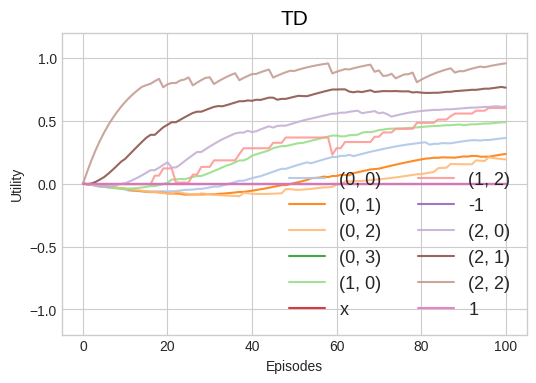

In [6]:
plt.figure(dpi = 100)
# style
plt.style.use('seaborn-whitegrid')
 
# create a color palette
palette = plt.get_cmap('tab20')
 
# multiple line plot
num=0
for column in df.drop('iter', axis=1):
    num+=1
    plt.plot(df['iter'], df[column], marker='', color=palette(num), linewidth=1.5, alpha=0.9, label=column)

# Add legend
plt.legend(loc=4, ncol=2, fontsize=13)
 
# Add titles
plt.title("TD", fontsize=15, fontweight=0, color='black')
plt.xlabel("Episodes")
plt.ylabel("Utility")
plt.ylim(-1.2,1.2)
plt.savefig("./td_graph.png", dpi=600)


In [18]:
Environment().generate_transition_model_2()[:,0,:]

array([[0.9, 0.8, 0. , 0. , 0.1, 0. , 0. , 0. , 0. , 0. , 0. , 0. ],
       [0. , 0.2, 0.8, 0. , 0. , 0.1, 0. , 0. , 0. , 0. , 0. , 0. ],
       [0. , 0. , 0.1, 0.8, 0. , 0. , 0.1, 0. , 0. , 0. , 0. , 0. ],
       [0. , 0. , 0. , 0.1, 0. , 0. , 0. , 0.1, 0. , 0. , 0. , 0. ],
       [0.1, 0. , 0. , 0. , 0.8, 0.8, 0. , 0. , 0.1, 0. , 0. , 0. ],
       [0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ],
       [0. , 0. , 0.1, 0. , 0. , 0. , 0.8, 0.8, 0. , 0. , 0.1, 0. ],
       [0. , 0. , 0. , 0.1, 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0.1],
       [0. , 0. , 0. , 0. , 0.1, 0. , 0. , 0. , 0.9, 0.8, 0. , 0. ],
       [0. , 0. , 0. , 0. , 0. , 0.1, 0. , 0. , 0. , 0.2, 0.8, 0. ],
       [0. , 0. , 0. , 0. , 0. , 0. , 0.1, 0. , 0. , 0. , 0.1, 0.8],
       [0. , 0. , 0. , 0. , 0. , 0. , 0. , 0.1, 0. , 0. , 0. , 0.1]])